In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import random
import sc_toolbox

from scipy.sparse import csr_matrix, isspmatrix
from datetime import datetime

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import utils as us
from src.utils import visualise as vs
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
library(edgeR)
library(limma)
# library(MAST)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


# Load Data

In [6]:
def index(data, name='Unnamed: 0'):
    data.index = pd.Index(data[name])
    data.drop([name], axis=1, inplace=True)
    return data

# ape = index(pd.read_csv('./Ape.csv'))
# human = index(pd.read_csv(config.PATHS.CSV/'human.csv'))

In [7]:
selected = index(pd.read_csv(config.PATHS.LOGS/'w2_markers.csv'), 'names')
selected.drop(['Unnamed: 0'], axis=1, inplace=True)

# GO

In [8]:
from pathlib import Path
if not Path(
    config.PATHS.CSV/"c2.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'symbols.gmt' https://figshare.com/ndownloader/files/35233771
    shutil.move(
        'symbols.gmt', config.PATHS.CSV/'c2.reactome.v7.5.1.symbols.gmt')

In [9]:
reactome = us.gmt_to_decoupler(
    config.PATHS.CSV/"c2.reactome.v7.5.1.symbols.gmt")
reactome.head()

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


In [10]:
# Retrieving via python
msigdb = dc.get_resource("MSigDB")
# Get reactome pathways
collection = config.PROTO.ENRICHMENT.COLLECTION
reactome = msigdb.query("collection == @collection")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]
reactome.head()

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,genesymbol,collection,geneset
2587,ABCA1,kegg_pathways,KEGG_ABC_TRANSPORTERS
3398,TUBB2A,kegg_pathways,KEGG_GAP_JUNCTION
3659,TUBB2A,kegg_pathways,KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION
3937,BMP2,kegg_pathways,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION
3962,BMP2,kegg_pathways,KEGG_TGF_BETA_SIGNALING_PATHWAY


In [11]:
# reactome.loc[:, 'geneset'] = [
#     '_'.join(name.split('_')[1:]) for name in reactome['geneset']]

In [12]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[
    (geneset_size > 5) & (geneset_size < 500)]

In [13]:
scores, norm, pvals = dc.run_gsea(
    # t_stats.T
    selected[selected.pvals_adj < .1][['pvals_adj']].T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


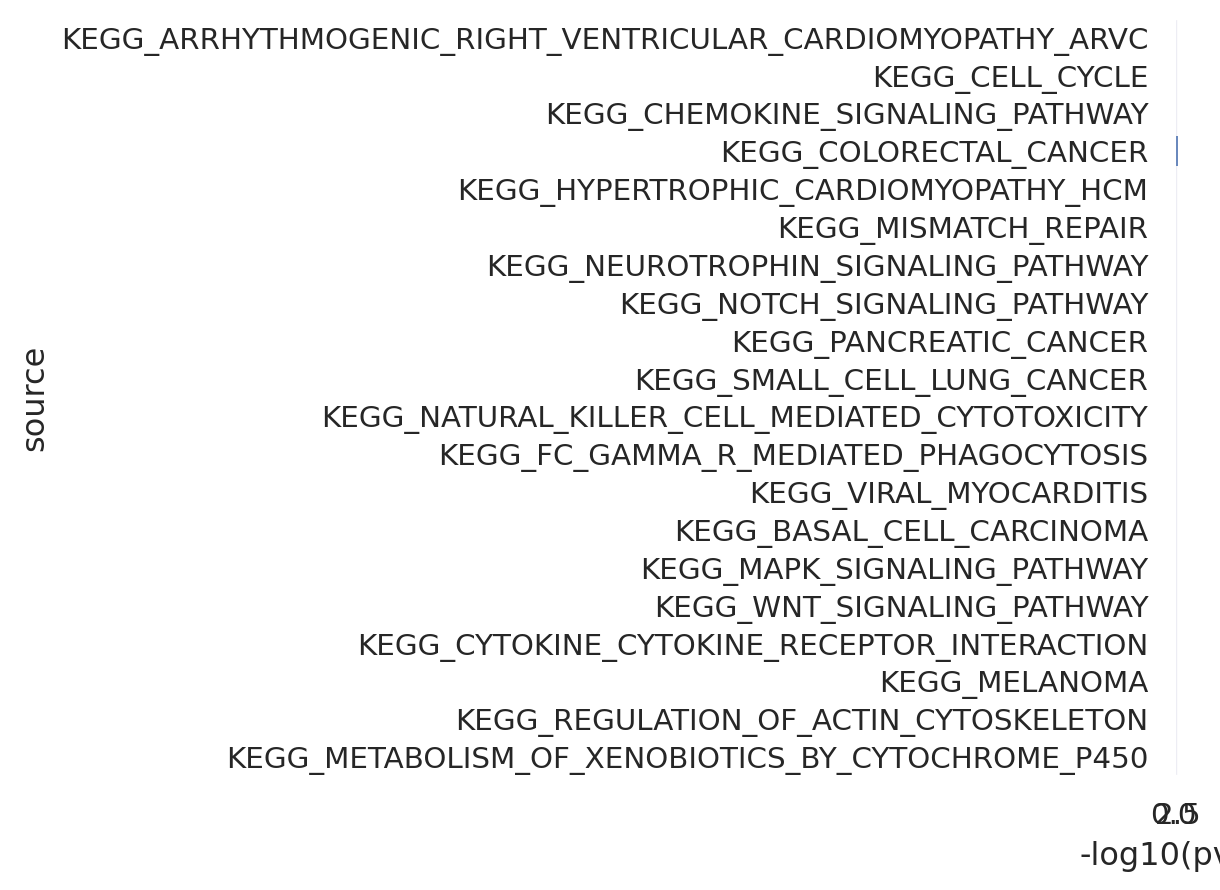

In [14]:
import seaborn.objects as so

(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [15]:
mat = selected[selected.pvals_adj < .1][['scores']].T.rename(index={'scores': 'isHuman'})
mat

names,CFI,COL23A1,WNT7B,EPHA1-AS1,RP3-460G2.2,TH,HIST1H2AB,PYDC1,SGCG,GLI1,...,BEX2,ATP1B1,MAP2,PEG10,BASP1,STMN1,GAP43,ATP5E,STMN2,MAP1B
isHuman,2.824141,2.914846,2.942848,2.942909,2.989825,2.993427,3.008124,3.025554,3.04427,3.04838,...,11.528459,11.561546,11.759745,12.989305,13.066587,13.768258,13.827157,13.846522,14.062592,14.100274


In [ ]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(
    organism='human', split_complexes=False)
collectri.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


In [17]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,AHR,AP1,AR,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,BCL6,...,TTF1,TWIST1,TWIST2,USF1,USF2,VDR,WT1,YBX1,YY1,ZBTB7A
isHuman,0.633745,0.610138,1.024655,0.119675,2.474296,0.792497,-0.635912,-0.495091,0.435428,-1.280875,...,0.101103,-0.929366,-0.658099,0.661529,0.080432,-0.62063,1.398106,0.303686,-0.483069,-1.750851


In [18]:
' '.join(tf_pvals.T[tf_pvals.T.isHuman < .01].index)

'CEBPB ID2 JUN JUNB MYB NEUROD1 NR2F1 REST TCF12 TCF3 TCF4'

In [19]:
' '.join(tf_acts.columns)

'AHR AP1 AR ARNT ASCL1 ATF1 ATF2 ATF3 ATF4 BCL6 BRCA1 CEBPA CEBPB CEBPD CEBPG CREB1 CREM CTCF CTNNB1 CUX1 DDIT3 DNMT1 E2F1 E2F2 E2F3 E2F4 EGR1 EGR2 EP300 EPAS1 ESR1 ESR2 ETS1 ETV4 EZH2 FLI1 FOS FOSB FOSL1 FOXA1 FOXA2 FOXM1 FOXN1 FOXO1 FOXO3 FOXP3 GATA1 GATA3 GATA4 GATA6 GLI1 GLI2 GLI3 HAND2 HDAC1 HES1 HEY1 HIF1A HMGA1 HMGA2 HNF1A HNF4A HR HSF1 ID1 ID2 IRF1 ISL1 JUN JUNB JUND KLF2 KLF4 KLF5 KLF6 KMT2A LEF1 MEF2A MEF2C MITF MYB MYBL2 MYC MYCN MYOD1 MYOG NANOG NCOA1 NCOR2 NEUROD1 NEUROG1 NEUROG3 NFATC1 NFATC2 NFE2L2 NFIC NFKB NFKB1 NFKB2 NFYA NFYB NKX2-1 NKX2-5 NR0B2 NR1H3 NR1H4 NR1I2 NR2F1 NR2F2 NR3C1 NR4A1 NR4A2 PAX3 PAX6 PBX1 PDX1 PGR PITX2 POU2F1 POU5F1 PPARA PPARD PPARG PRDM1 RARA RBPJ REL RELA REST RUNX1 RUNX2 RUNX3 RXRA SIRT1 SMAD1 SMAD2 SMAD3 SMAD4 SNAI1 SNAI2 SOX2 SOX9 SP1 SP3 SPI1 SREBF1 SRF SSRP1 STAT1 STAT3 STAT5A STAT5B STAT6 TAL1 TBP TBPL1 TCF12 TCF3 TCF4 TCF7L2 TFAP2A TFAP2B TFCP2 TFDP1 TP53 TP63 TP73 TTF1 TWIST1 TWIST2 USF1 USF2 VDR WT1 YBX1 YY1 ZBTB7A'

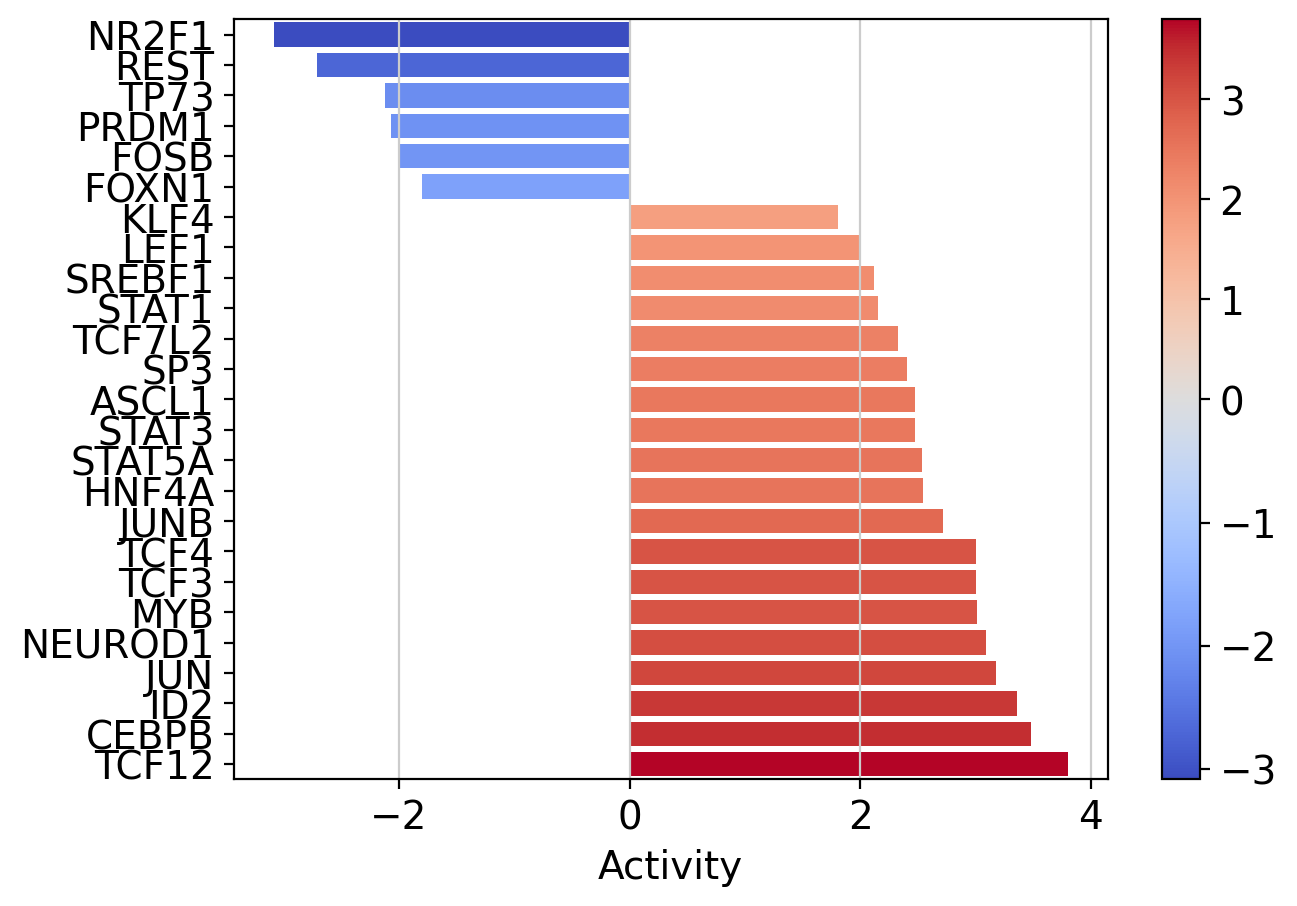

In [20]:
dc.plot_barplot(tf_acts, 'isHuman', top=25, vertical=True)

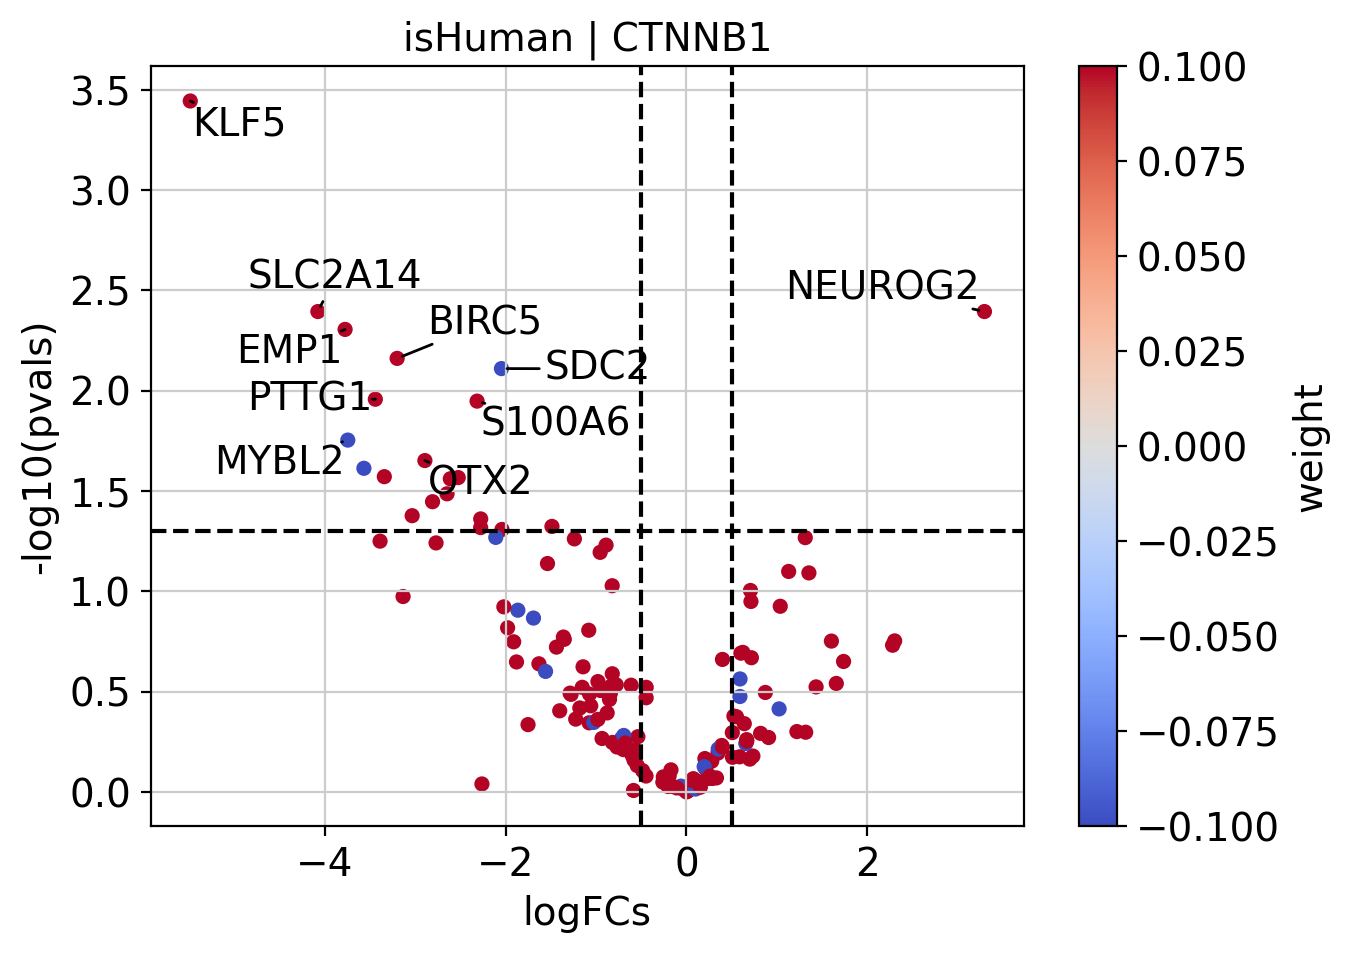

In [21]:
# Extract logFCs and pvals
logFCs = selected[['logfoldchanges']].T.rename(index={'logfoldchanges': 'isHuman'})
pvals = selected[['pvals_adj']].T.rename(index={'pvals_adj': 'isHuman'})

# Plot
dc.plot_volcano(
    logFCs, pvals, 'isHuman', name='CTNNB1', net=collectri,
    top=10, sign_thr=0.05, lFCs_thr=0.5)

In [24]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=selected[selected.pvals_adj < .01],
    net=reactome,
    source='geneset',
    target='genesymbol',
)

enr_pvals.sort_values('FDR p-value').head(10)

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,KEGG_ACUTE_MYELOID_LEUKEMIA,57,0.035088,0.122391,0.669161,4.119281,8.652695,PIK3R3;RUNX1T1
62,KEGG_PANCREATIC_CANCER,70,0.042857,0.038282,0.669161,4.722947,15.409935,E2F2;PIK3R3;RALGDS
60,KEGG_OTHER_GLYCAN_DEGRADATION,16,0.062500,0.156816,0.669161,8.589942,15.914454,HEXB
26,KEGG_ECM_RECEPTOR_INTERACTION,84,0.047619,0.012242,0.669161,5.087012,22.397347,COL6A1;ITGA6;SDC1;SDC2
59,KEGG_NOTCH_SIGNALING_PATHWAY,47,0.042553,0.088659,0.669161,4.988999,12.088112,DLL3;MAML3
58,KEGG_NON_SMALL_CELL_LUNG_CANCER,54,0.037037,0.111965,0.669161,4.346684,9.517373,E2F2;PIK3R3
56,KEGG_NEUROTROPHIN_SIGNALING_PATHWAY,126,0.023810,0.149825,0.669161,2.624761,4.982555,IRAK1;NTF4;PIK3R3
54,KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY,136,0.022059,0.175426,0.669161,2.431247,4.231674,HLA-E;PIK3R3;ULBP2
63,KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION,55,0.054545,0.020571,0.669161,6.003935,23.318378,TUBA1C;TUBA4A;TUBB6
34,KEGG_GAP_JUNCTION,89,0.033708,0.068801,0.669161,3.716764,9.948044,TUBA1C;TUBA4A;TUBB6


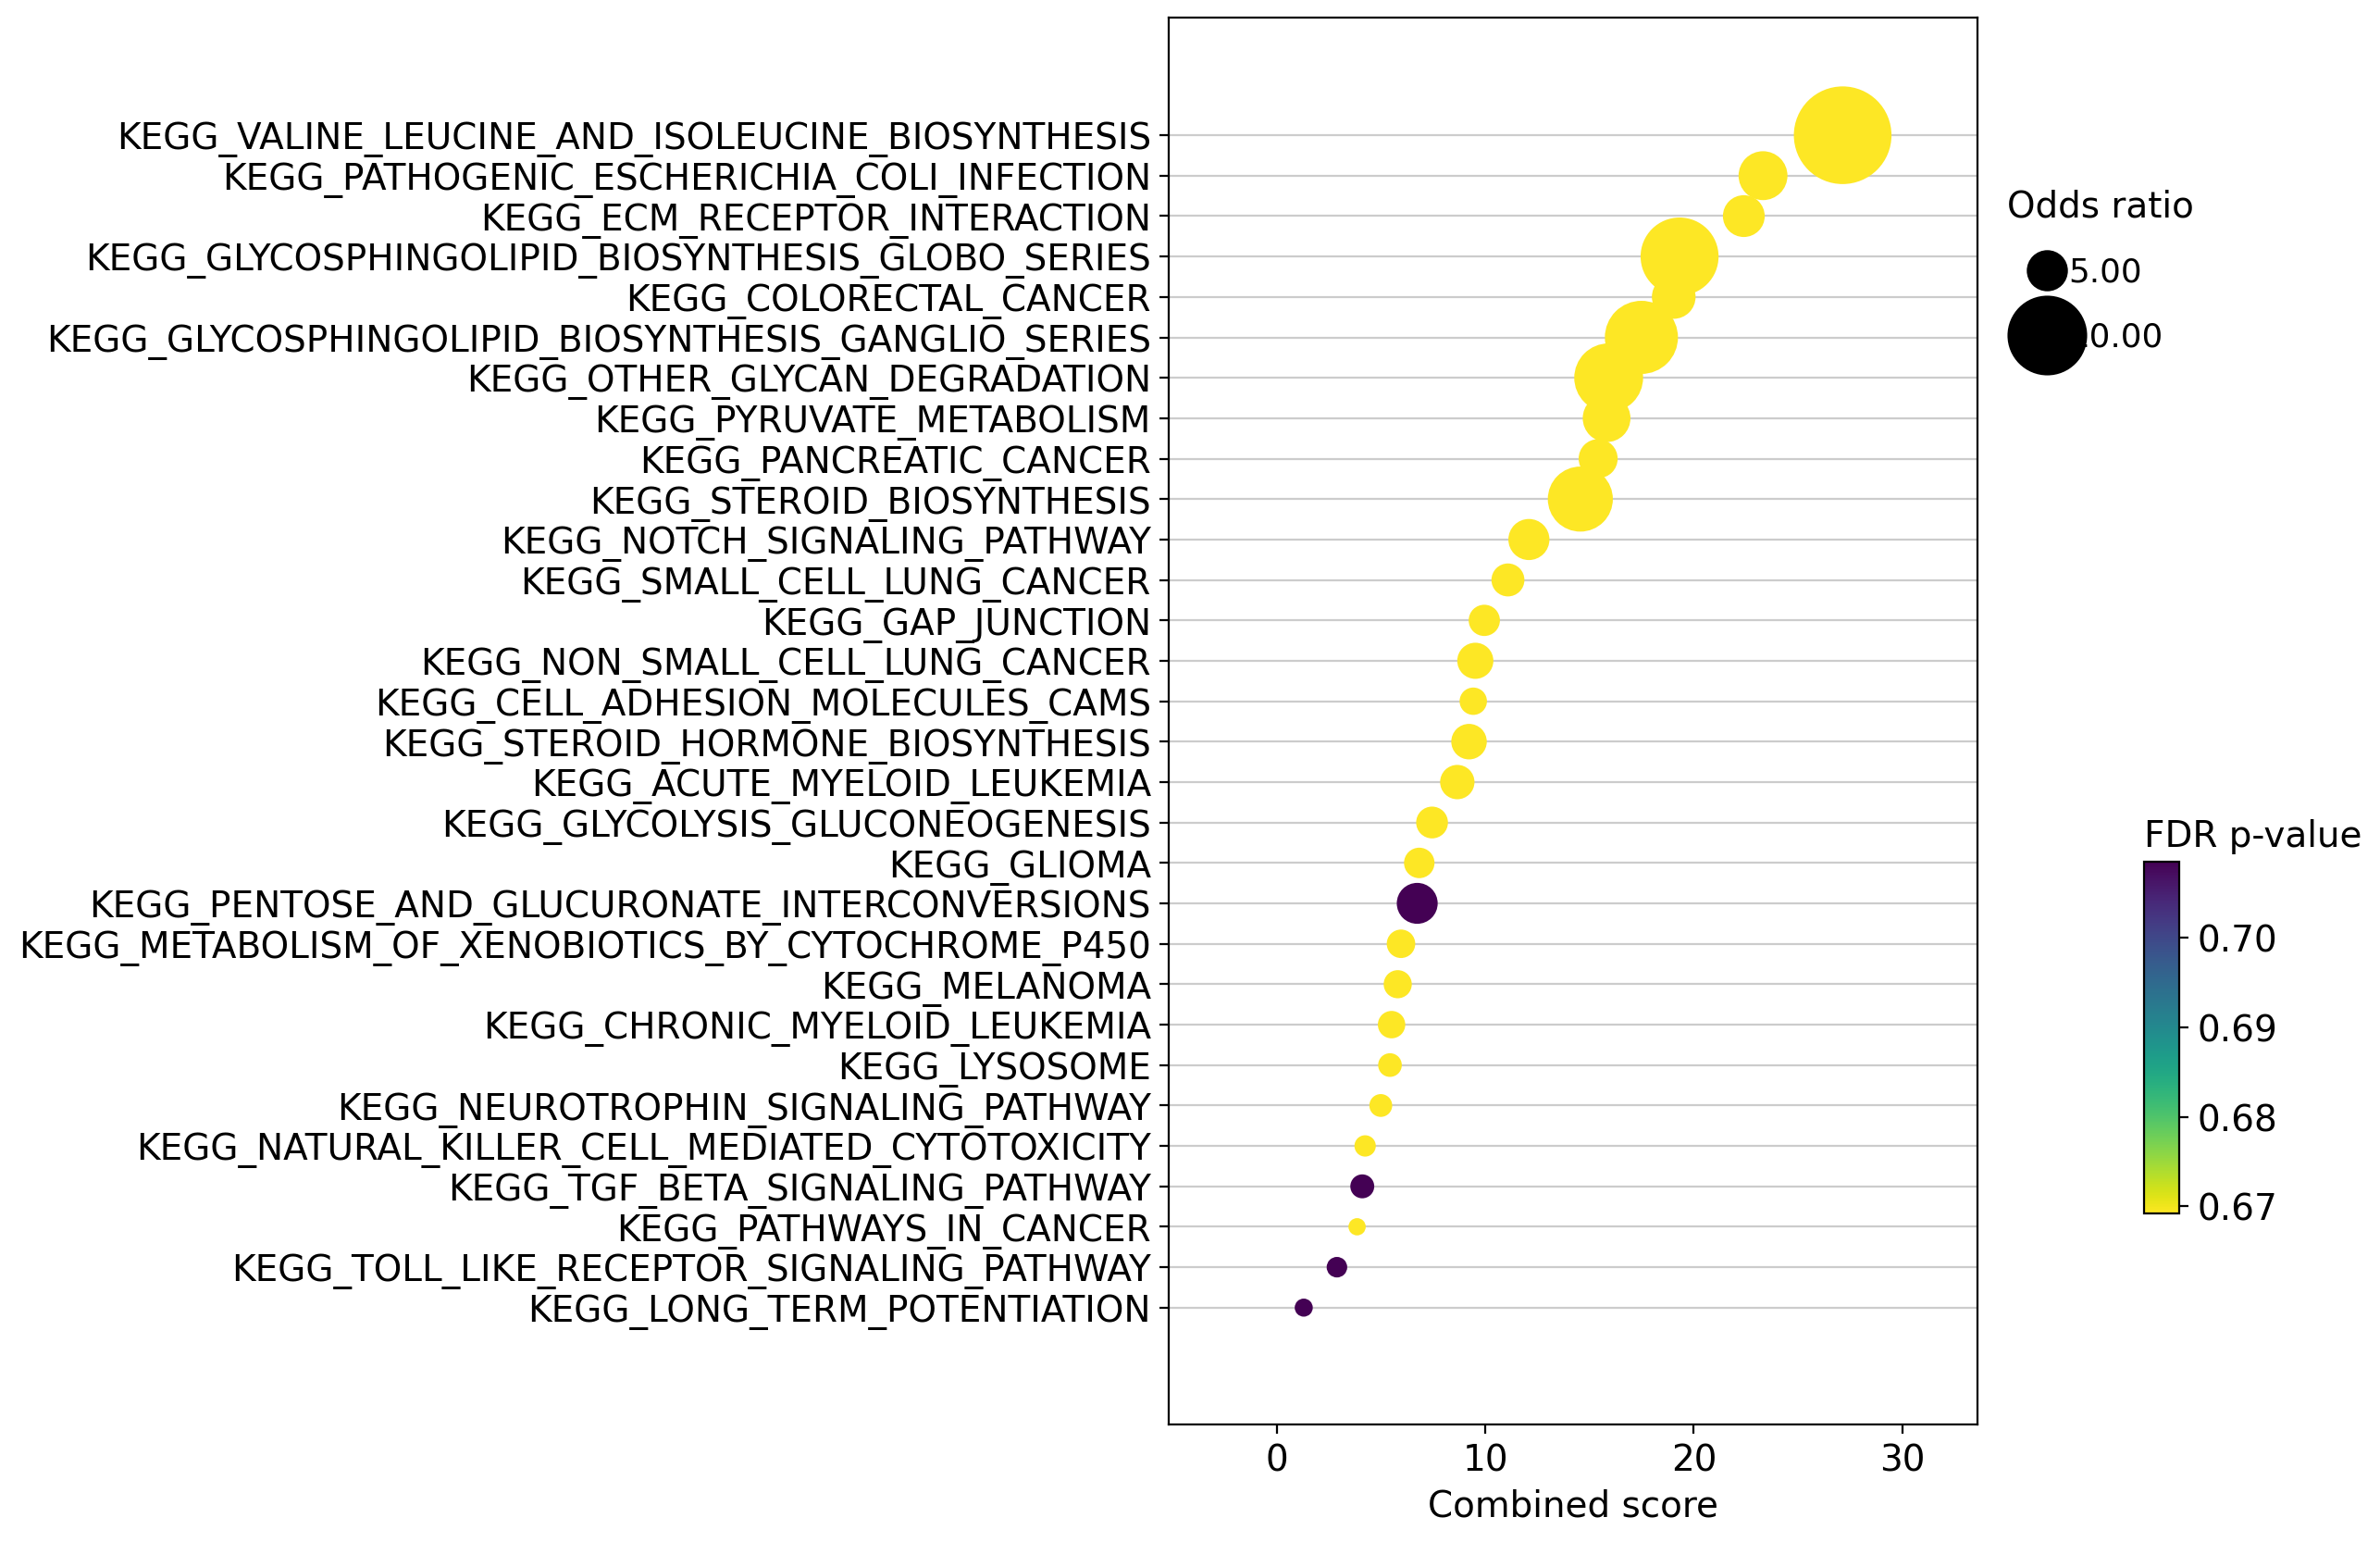

In [25]:
dc.plot_dotplot(
    enr_pvals.sort_values('FDR p-value').head(30), x='Combined score', y='Term', 
    s='Odds ratio', c='FDR p-value', scale=0.5, figsize=(7,10))

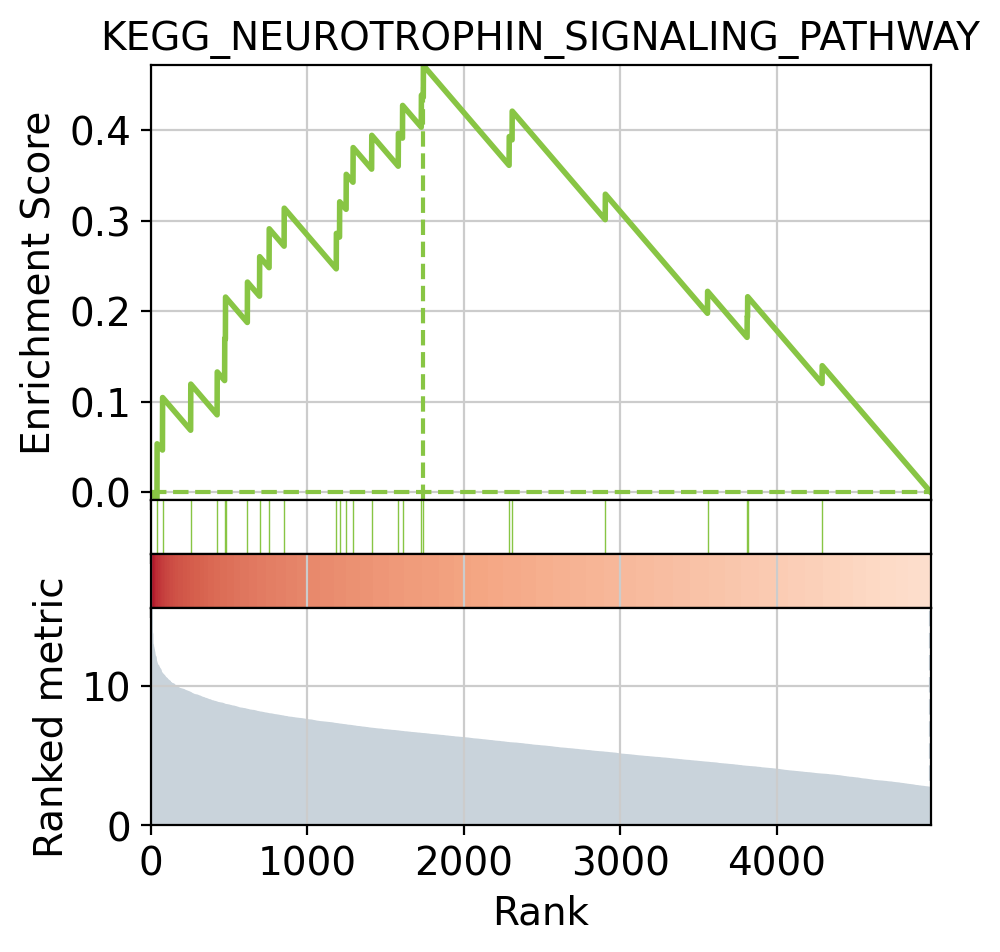

In [22]:
dc.plot_running_score(
    selected,
    stat='scores',
    net=reactome,
    source='geneset',
    target='genesymbol',
    set_name='KEGG_NEUROTROPHIN_SIGNALING_PATHWAY'
)

In [23]:
selected = index(
    pd.read_csv(config.PATHS.LOGS/'w4_markers.csv'), 'names')
selected.drop(['Unnamed: 0'], axis=1, inplace=True)

In [24]:
scores, norm, pvals = dc.run_gsea(
    # t_stats.T
    selected[selected.pvals_adj < .1][['pvals_adj']].T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
    min_n=5
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


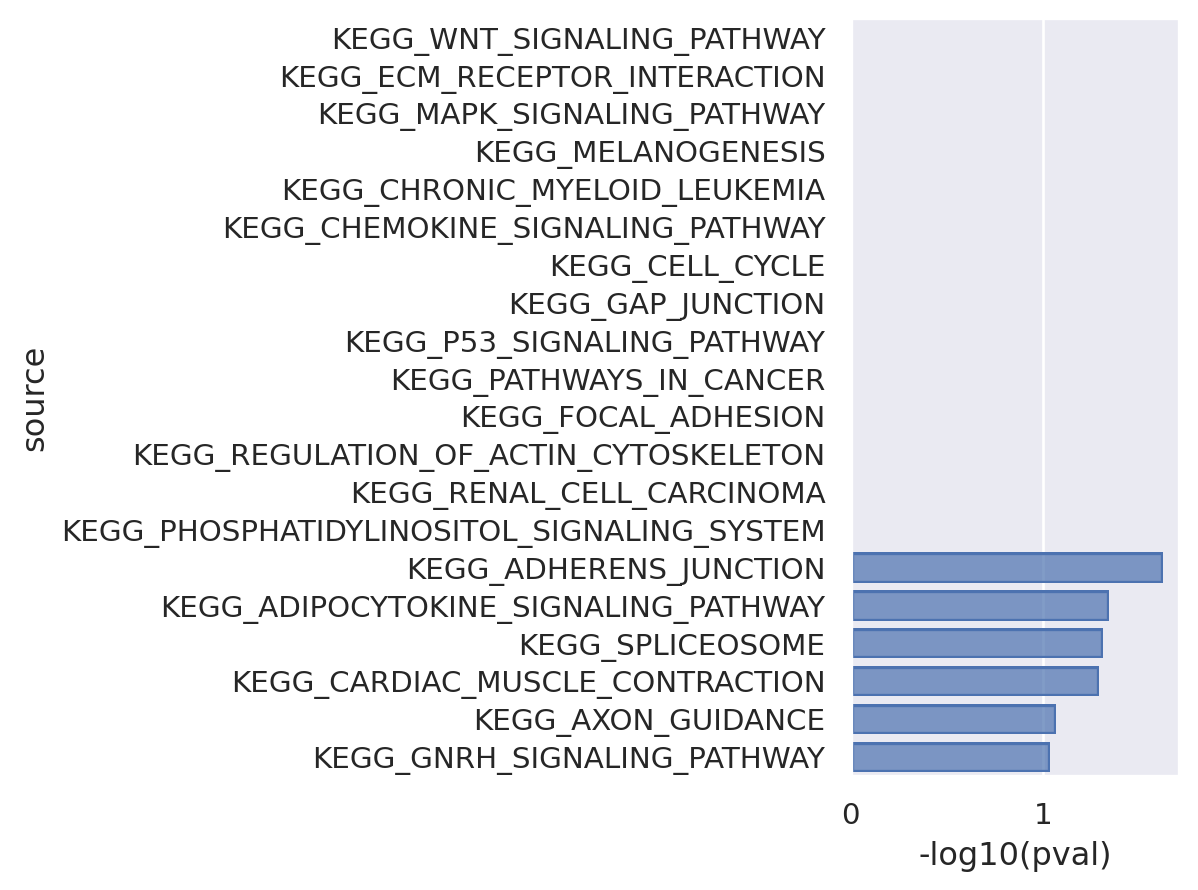

In [25]:
import seaborn.objects as so

(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [26]:
mat = selected[selected.pvals_adj < .1][['scores']].T.rename(index={'scores': 'isHuman'})
mat

names,SULT1E1,TMEM92,ZNF229,DSC3,IFITM1,TMEM133,TM4SF1,PRRX2,HOXA10,SH3RF2,...,MARCKSL1,STMN1,NEFM,GAP43,MAP1B,PCSK1N,NEFL,STMN2,ATP5E,TMSB10
isHuman,2.69794,2.701614,2.701614,2.763896,2.763896,2.765055,2.771697,2.771697,2.773582,2.777507,...,12.822192,12.939121,12.939977,13.499663,13.518009,13.696975,13.869692,14.066242,14.255675,16.110047


In [27]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,AHR,AP1,APEX1,AR,ARID4B,ARNT,ARX,ASCL1,ATF1,ATF2,...,ZBTB7B,ZEB1,ZEB2,ZFP42,ZIC1,ZNF143,ZNF148,ZNF331,ZNF699,ZNF91
isHuman,-0.091134,0.610757,0.643711,1.020214,0.599353,-0.64942,-0.36615,0.548292,-0.56258,-1.173441,...,-1.216027,-0.739012,-1.875696,0.475227,1.630415,-0.397083,0.441577,0.5906,0.79055,-0.914594


In [28]:
' '.join(tf_pvals.T[tf_pvals.T.isHuman < .01].index)

'ESR1 HNF4A ISL1 KLF10 MSX1 REST TCF12'

In [29]:
' '.join(tf_acts.columns)

'AHR AP1 APEX1 AR ARID4B ARNT ARX ASCL1 ATF1 ATF2 ATF3 ATF4 BARX2 BCL11B BCL6 BHLHE40 BHLHE41 BMAL1 BRCA1 CDX1 CDX2 CEBPA CEBPB CEBPD CEBPG CREB1 CREBBP CREM CTCF CTNNB1 CUX1 DBP DDIT3 DLX2 DLX4 DLX5 DMTF1 DNMT1 DNMT3A DNMT3B E2F1 E2F2 E2F3 E2F4 E2F5 EGR1 EGR2 ELF3 ELF4 ELK1 ELK3 ENO1 EOMES EP300 EPAS1 ERG ESR1 ESR2 ETS1 ETS2 ETV4 ETV6 EWSR1 EZH2 FLI1 FOS FOSB FOSL1 FOSL2 FOXA1 FOXA2 FOXJ1 FOXL2 FOXM1 FOXN1 FOXO1 FOXO3 FOXP3 GABPA GATA1 GATA2 GATA3 GATA4 GATA6 GFI1 GLI1 GLI2 GLI3 GTF3A HAND2 HBP1 HDAC1 HDAC3 HDAC4 HES1 HIC1 HIF1A HLX HMGA1 HMGA2 HNF1A HNF1B HNF4A HOXA1 HOXA10 HOXA5 HOXA9 HOXB7 HOXC6 HOXD13 HR HSF1 HSF2 HTATIP2 ID1 ID2 ID3 ING4 IRF1 IRF2 IRF3 IRF8 IRF9 ISL1 JDP2 JUN JUNB JUND KAT5 KAT7 KDM5B KLF10 KLF2 KLF4 KLF5 KLF6 KLF9 KMT2A LEF1 LHX2 LMO2 MAF MAFB MAFK MAX MBD1 MBD2 MECOM MEF2A MEF2C MEIS1 MITF MSC MSX1 MSX2 MTA1 MTF1 MYB MYBL2 MYC MYCN MYOD1 MYOG NANOG NCOA1 NCOA2 NCOA3 NCOR1 NCOR2 NEUROD1 NEUROG2 NEUROG3 NFAT5 NFATC1 NFATC2 NFATC4 NFE2L2 NFIA NFIB NFIC NFIX NFKB N

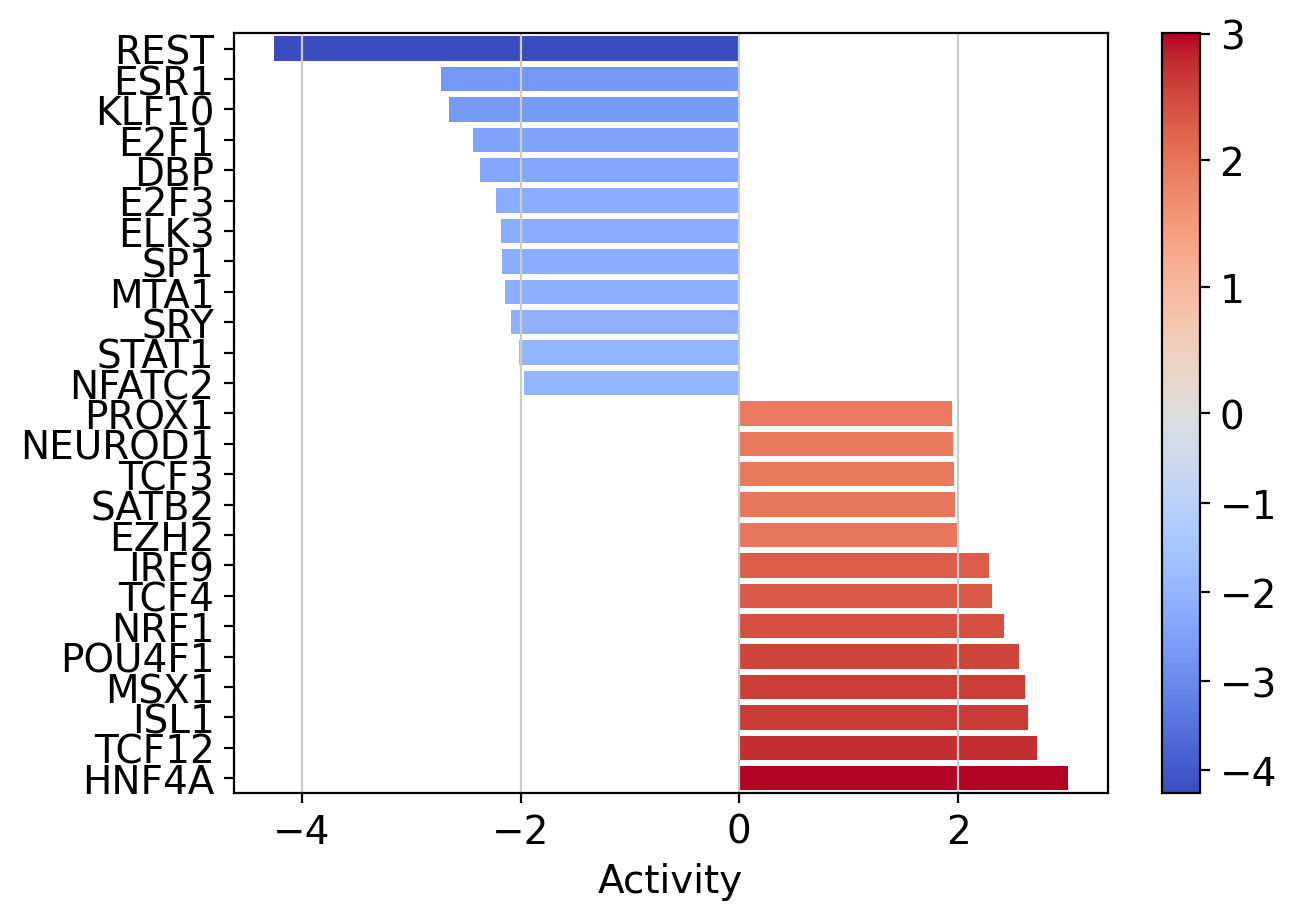

In [30]:
dc.plot_barplot(tf_acts, 'isHuman', top=25, vertical=True)

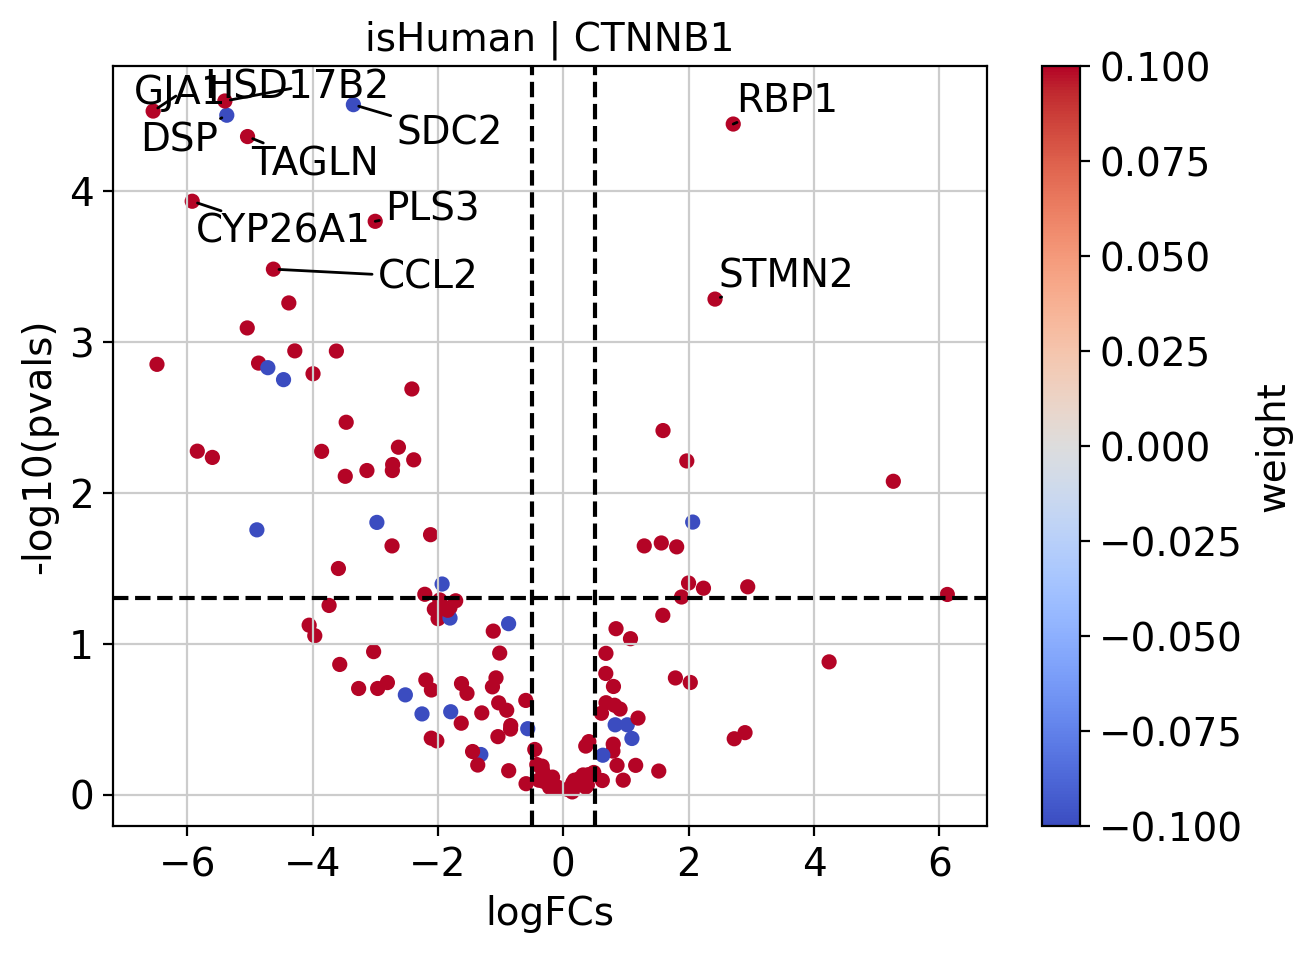

In [31]:
# Extract logFCs and pvals
logFCs = selected[['logfoldchanges']].T.rename(index={'logfoldchanges': 'isHuman'})
pvals = selected[['pvals_adj']].T.rename(index={'pvals_adj': 'isHuman'})

# Plot
dc.plot_volcano(
    logFCs, pvals, 'isHuman', name='CTNNB1', net=collectri,
    top=10, sign_thr=0.05, lFCs_thr=0.5)

In [32]:
selected['group'] = 'a'
selected['cname'] = selected.index

In [33]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=selected[selected.pvals_adj < .05],
    net=reactome,
    source='geneset',
    target='genesymbol',
)

enr_pvals.sort_values('FDR p-value').head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
24,KEGG_CELL_CYCLE,124,0.233871,1.057739e-10,1.533722e-08,4.107887,94.357009,CCNA2;CCNB1;CCNB2;CCND1;CCND2;CDC20;CDC25C;CDC...
36,KEGG_ECM_RECEPTOR_INTERACTION,84,0.250000,1.104121e-08,8.004879e-07,4.389356,80.420166,COL11A1;COL1A1;COL2A1;COL3A1;COL4A6;COL5A1;COL...
100,KEGG_PATHWAYS_IN_CANCER,325,0.132308,5.286067e-07,2.554932e-05,2.321805,33.557104,APC;APC2;CBLC;CCND1;CDK2;CDKN1A;CKS1B;COL4A6;E...
96,KEGG_P53_SIGNALING_PATHWAY,68,0.235294,1.470856e-06,5.331854e-05,4.140801,55.609578,CCNB1;CCNB2;CCND1;CCND2;CDK1;CDK2;CDKN1A;GADD4...
45,KEGG_FOCAL_ADHESION,199,0.145729,5.579125e-06,1.617946e-04,2.553896,30.893144,CCND1;CCND2;COL11A1;COL1A1;COL2A1;COL3A1;COL4A...


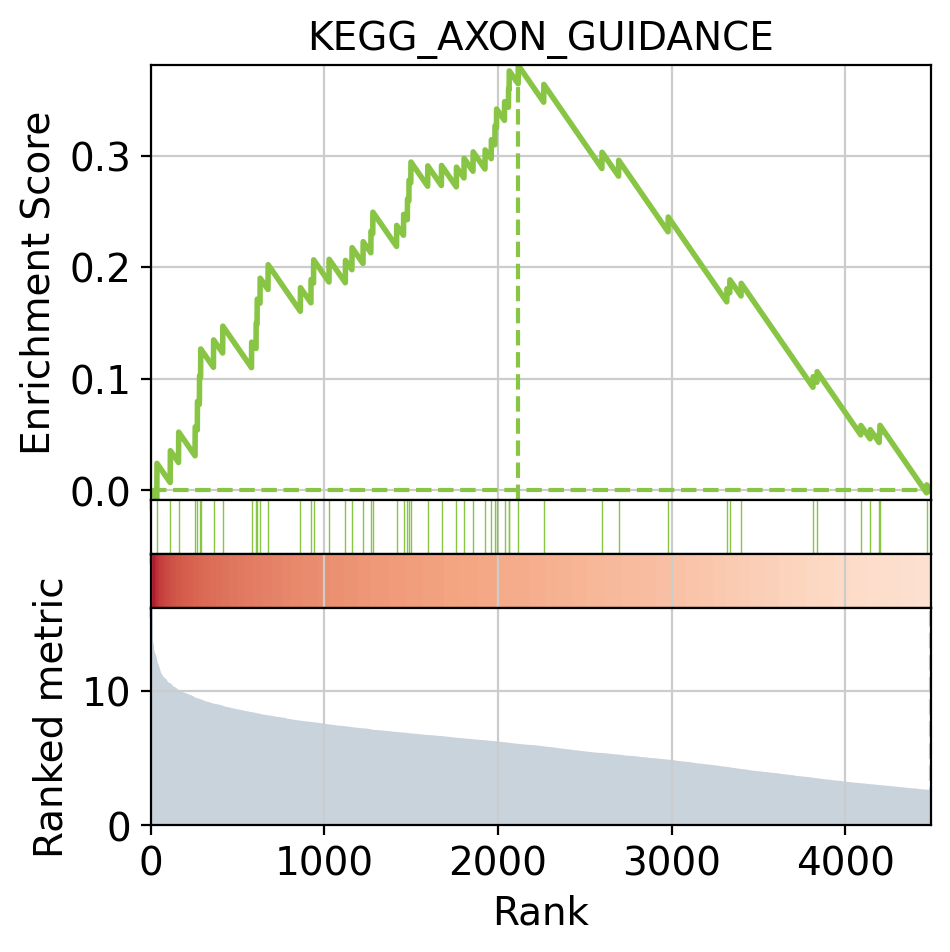

In [35]:
dc.plot_running_score(
    selected,
    stat='scores',
    net=reactome,
    source='geneset',
    target='genesymbol',
    set_name='KEGG_AXON_GUIDANCE'
)

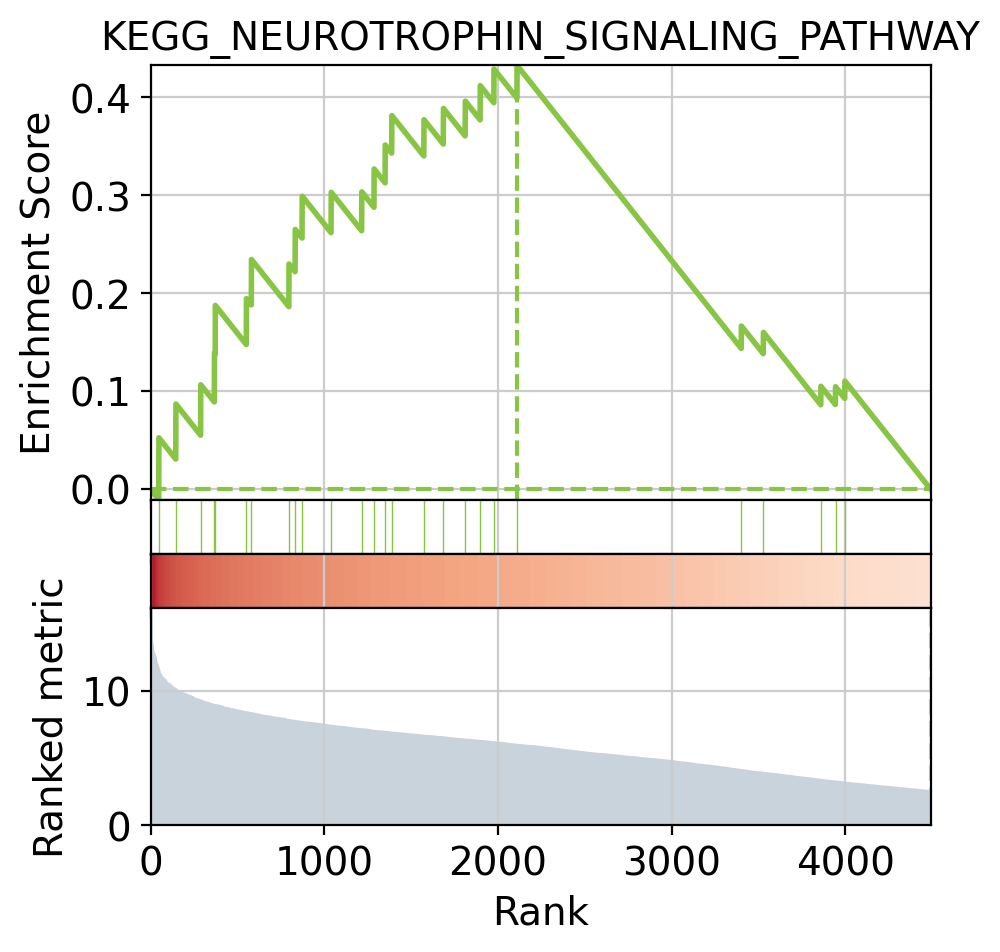

In [34]:
dc.plot_running_score(
    selected,
    stat='scores',
    net=reactome,
    source='geneset',
    target='genesymbol',
    set_name='KEGG_NEUROTROPHIN_SIGNALING_PATHWAY'
)

In [36]:
selected = index(
    pd.read_csv(config.PATHS.LOGS/'w5_markers.csv'), 'names')
selected.drop(['Unnamed: 0'], axis=1, inplace=True)

In [37]:
scores, norm, pvals = dc.run_gsea(
    # t_stats.T
    selected[selected.pvals_adj < .1][['pvals_adj']].T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
    min_n=5
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


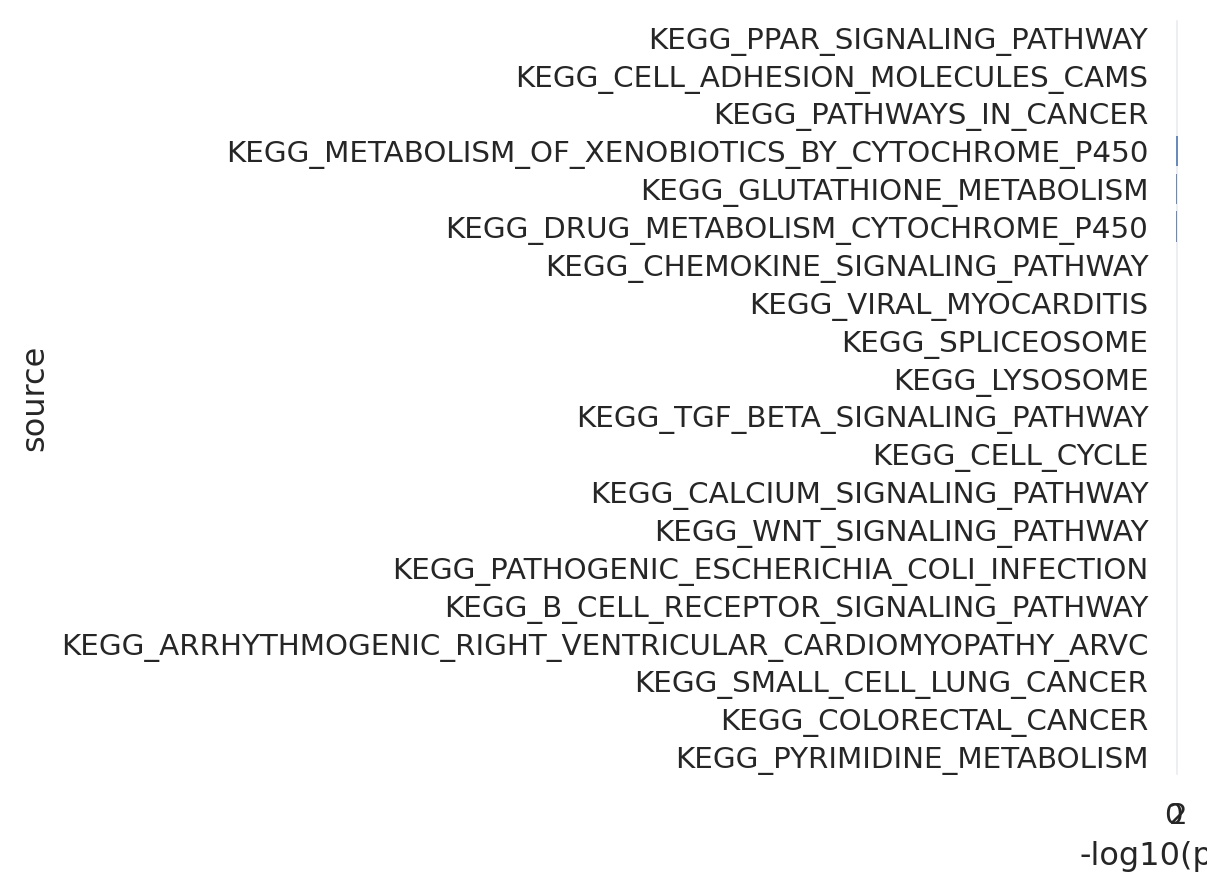

In [38]:
import seaborn.objects as so

(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [39]:
mat = selected[selected.pvals_adj < .1][['scores']].T.rename(index={'scores': 'isHuman'})
mat

names,DDX60,ANKRD33B,AC119673.1,CTC-360G5.9,AC026150.5,CTB-193M12.5,DLEU2L,PRDM13,E2F2,RP11-479O17.10,...,BEX2,PFN1,MLLT11,PEG10,CCNI,MARCKSL1,BASP1,MDK,MAP1B,NEFM
isHuman,2.895138,2.921656,2.931902,2.939746,2.944236,2.945713,2.946596,2.971268,2.977369,3.00298,...,11.622795,11.761708,11.824255,11.958285,12.191216,12.27707,12.357817,12.612426,13.551363,13.561825


In [40]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,AHR,AP1,APEX1,AR,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,YY1,ZBTB16,ZBTB7B,ZEB1,ZEB2,ZNF354C,ZNF362,ZNF384,ZNF699,ZNF91
isHuman,-0.053454,2.294923,1.190634,2.738971,-1.171074,1.082887,0.757474,1.427831,1.209523,0.666917,...,-1.01417,0.746926,0.594669,-0.471695,0.804384,-0.086438,2.362238,1.223673,0.094914,1.46134


In [41]:
' '.join(tf_pvals.T[tf_pvals.T.isHuman < .01].index)

'AR CEBPG CREM EGR1 HR JUN JUNB MYB MYC NEUROD1 NFE2L2 NFIA RARA RARB SMAD3 SMAD4 SP1 STAT3 TBP'

In [42]:
' '.join(tf_acts.columns)

'AHR AP1 APEX1 AR ARNT ASCL1 ATF1 ATF2 ATF3 ATF4 ATF6 BCL6 BRCA1 CDX2 CEBPA CEBPB CEBPD CEBPG CEBPZ CLOCK CREB1 CREM CRX CTCF CTNNB1 CUX1 DDIT3 DLX4 DNMT1 DNMT3A DNMT3B E2F1 E2F3 E2F4 EBF1 EGR1 EGR2 EOMES EP300 EPAS1 ERG ESR1 ESR2 ETS1 ETS2 ETV4 EWSR1 EZH2 FEZF1 FLI1 FOS FOSB FOSL1 FOXA1 FOXA2 FOXM1 FOXN1 FOXO1 FOXO3 FOXP3 GATA1 GATA2 GATA3 GATA4 GATA6 GLI1 GLI2 GLI3 HAND2 HBP1 HDAC1 HES1 HEY1 HEY2 HIF1A HMGA1 HMGA2 HNF1A HNF1B HNF4A HOXA10 HOXA9 HR HSF1 ID1 ID2 ID3 IRF1 IRF8 JUN JUNB JUND KAT7 KDM5B KLF2 KLF4 KLF5 KLF6 KMT2A LEF1 LMO2 MAX MAZ MBD2 MECOM MEF2A MEF2C MITF MSX1 MSX2 MTA1 MYB MYBL2 MYC MYCN MYOD1 MYOG NANOG NCOR2 NEUROD1 NEUROG3 NFATC1 NFE2L2 NFIA NFIB NFIC NFIX NFKB NFKB1 NFKB2 NFYA NFYB NFYC NKX2-1 NKX2-5 NOTCH1 NR0B1 NR0B2 NR1H3 NR1H4 NR1I2 NR2F1 NR2F2 NR3C1 NR3C2 NR4A2 NR5A1 NRF1 PAX3 PAX5 PAX6 PBX1 PDX1 PGR PHOX2B PITX1 PITX2 POU2F1 POU2F2 POU5F1 PPARA PPARD PPARG PRDM1 PROX1 PTF1A RARA RARB RARG RB1 RBPJ REL RELA REST RORA RUNX1 RUNX2 RUNX3 RXRA SALL4 SATB2 SIRT1 SK

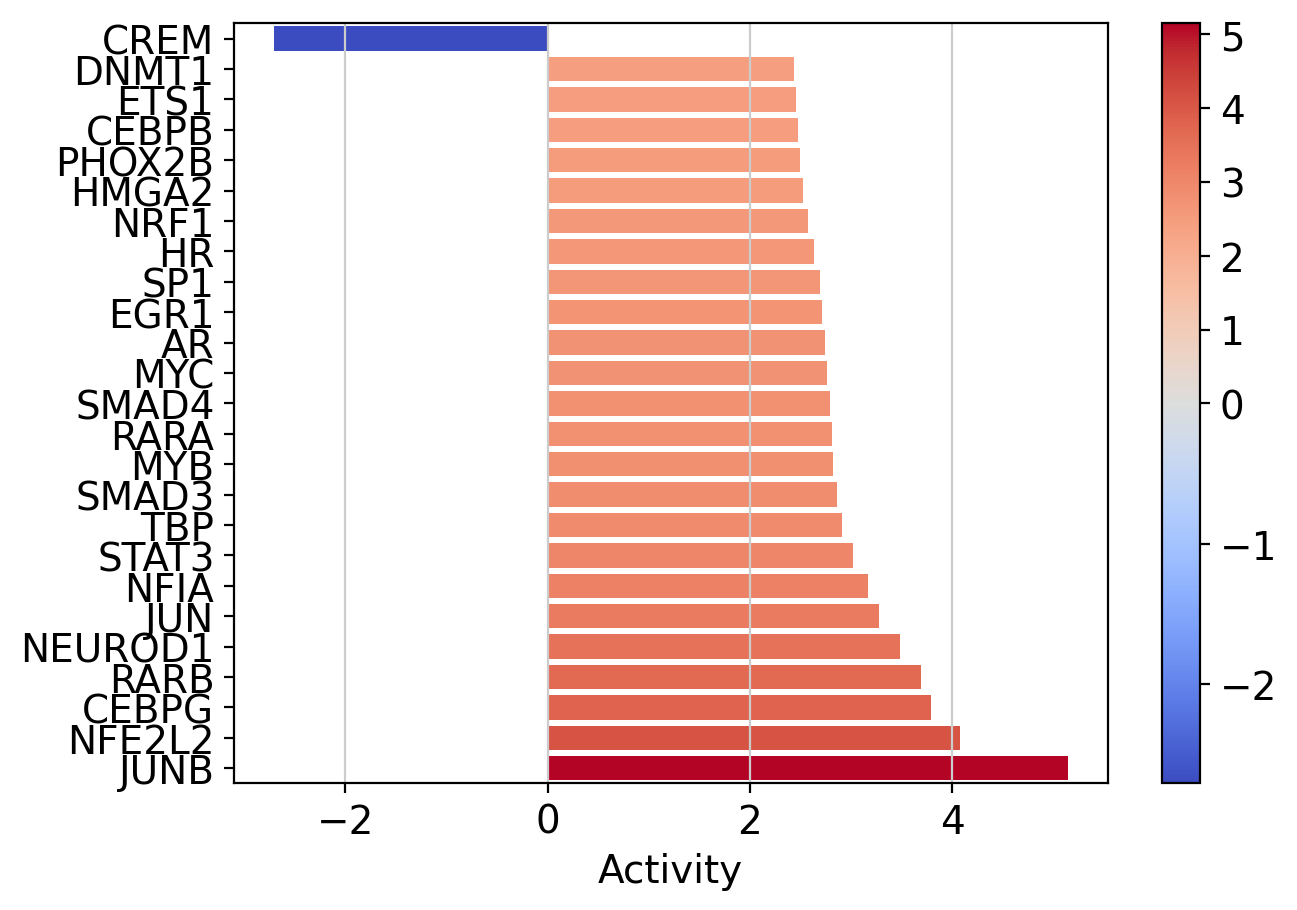

In [43]:
dc.plot_barplot(tf_acts, 'isHuman', top=25, vertical=True)

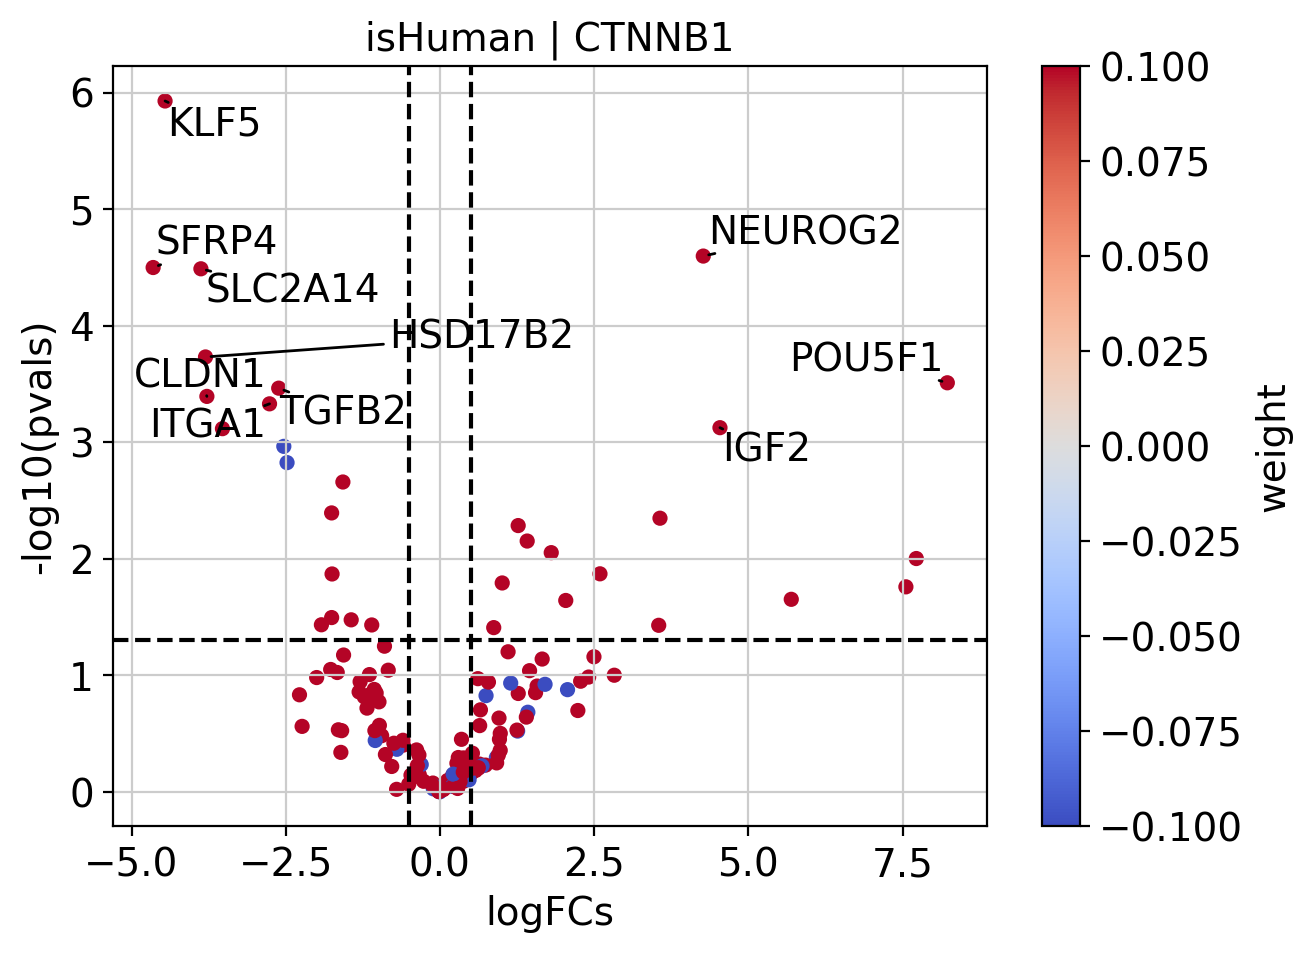

In [44]:
# Extract logFCs and pvals
logFCs = selected[['logfoldchanges']].T.rename(index={'logfoldchanges': 'isHuman'})
pvals = selected[['pvals_adj']].T.rename(index={'pvals_adj': 'isHuman'})

# Plot
dc.plot_volcano(
    logFCs, pvals, 'isHuman', name='CTNNB1', net=collectri,
    top=10, sign_thr=0.05, lFCs_thr=0.5)

In [45]:
selected['group'] = 'a'
selected['cname'] = selected.index

In [46]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=selected[selected.pvals_adj < .05],
    net=reactome,
    source='geneset',
    target='genesymbol',
)

enr_pvals.sort_values('FDR p-value').head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
37,KEGG_ECM_RECEPTOR_INTERACTION,84,0.178571,0.000011,0.001575,3.835509,43.893354,COL11A1;COL1A1;COL1A2;COL6A1;FN1;ITGA1;ITGA4;I...
23,KEGG_CELL_ADHESION_MOLECULES_CAMS,133,0.127820,0.000235,0.017241,2.739983,22.900057,CDH1;CLDN1;CLDN11;CLDN23;CLDN3;CLDN4;CLDN6;CLD...
132,KEGG_TIGHT_JUNCTION,132,0.098485,0.011612,0.349149,2.120836,9.449798,CLDN1;CLDN11;CLDN23;CLDN3;CLDN4;CLDN6;CLDN7;LL...
99,KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION,55,0.127273,0.016228,0.349149,2.806182,11.564270,CDH1;CLDN1;EZR;OCLN;TUBA1C;TUBA4A;TUBB8
46,KEGG_FOCAL_ADHESION,199,0.085427,0.016626,0.349149,1.827432,7.486581,CCND2;COL11A1;COL1A1;COL1A2;COL6A1;FN1;ITGA1;I...


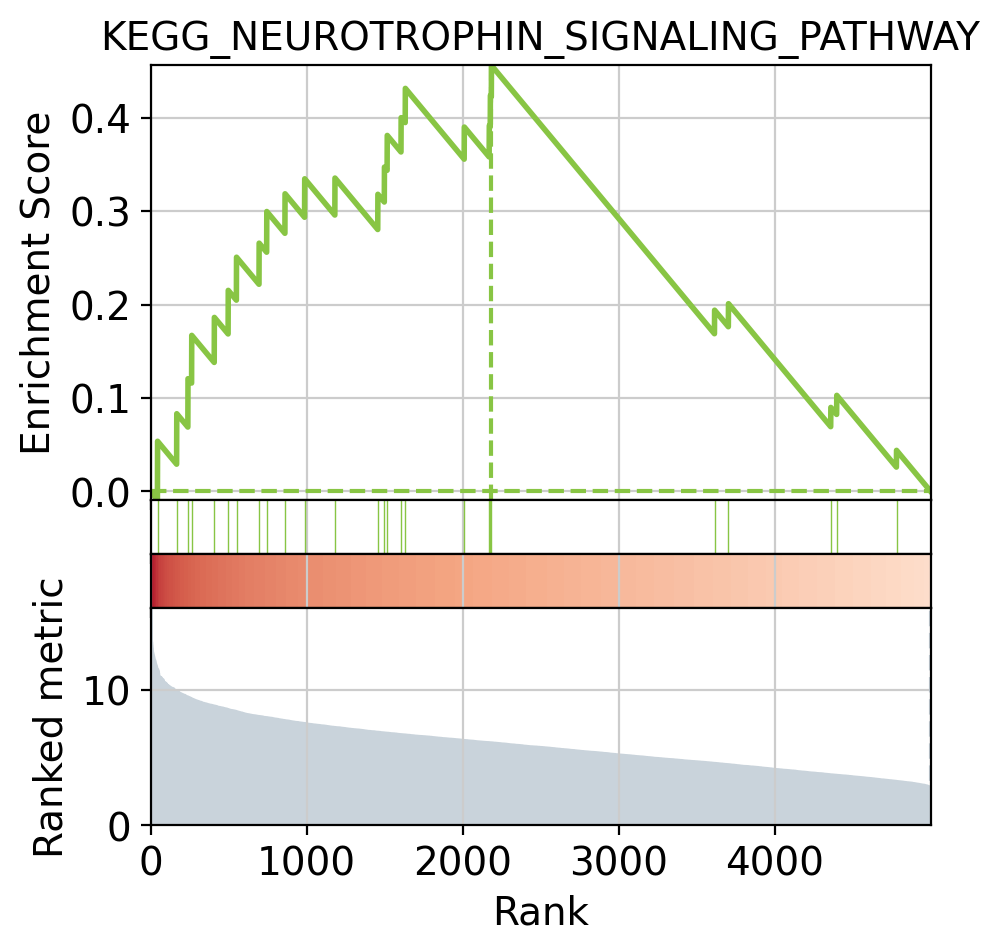

In [47]:
dc.plot_running_score(
    selected,
    stat='scores',
    net=reactome,
    source='geneset',
    target='genesymbol',
    set_name='KEGG_NEUROTROPHIN_SIGNALING_PATHWAY'
)

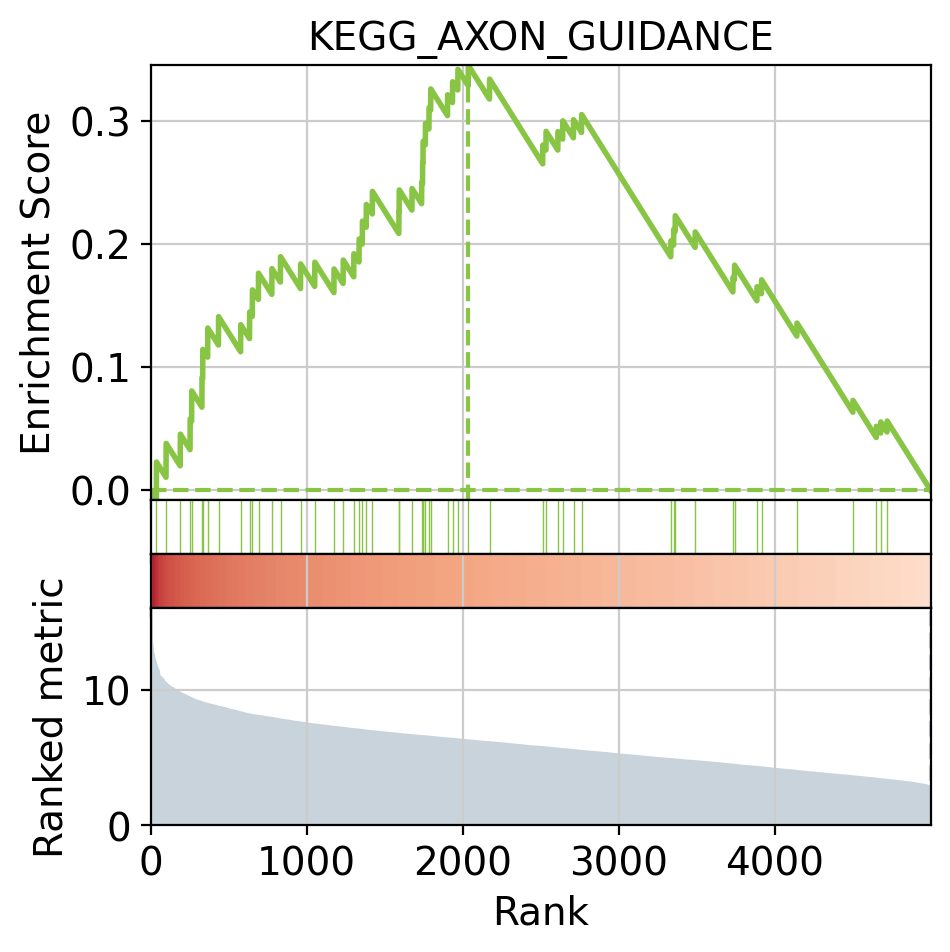

In [48]:
dc.plot_running_score(
    selected,
    stat='scores',
    net=reactome,
    source='geneset',
    target='genesymbol',
    set_name='KEGG_AXON_GUIDANCE'
)

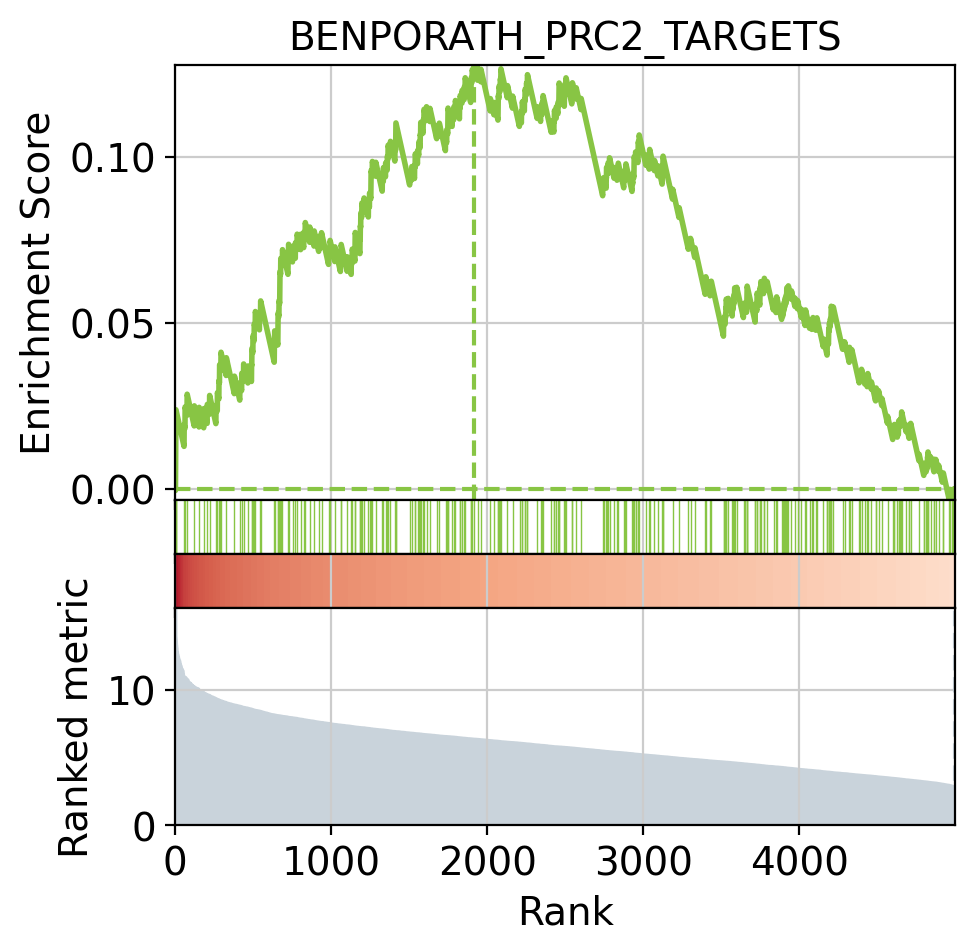

In [64]:
dc.plot_running_score(
    selected,
    stat='scores',
    net=reactome,
    source='geneset',
    target='genesymbol',
    set_name='BENPORATH_PRC2_TARGETS'
)